In [26]:
import matplotlib.pyplot as plt

import jax
from jax import numpy as jnp, random, jit, vmap, grad, nn
from functools import partial

import jax_dataloader as jdl
import optax

import haiku as hk

import numpy as np
from sklearn import metrics, model_selection

rng = hk.PRNGSequence(0)

In [2]:
from torch.utils import data
from torchvision.datasets import MNIST

/home/docker/mambaforge/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libjpeg.so.8: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [3]:
mnist = MNIST('/tmp/mnist', download=True,
              transform=lambda x:np.array(x,dtype=jnp.float32).ravel())

dataloader = jdl.DataLoader(mnist, backend='pytorch',
                            batch_size=len(mnist))

batch = next(iter(dataloader))

In [4]:
def make_model():    
    return hk.Linear(len(mnist.classes))

def predict(x):
    model = make_model()
    logits = model(x)
    return jnp.argmax(logits, axis=-1)

def point_loss(x,y):
    model = make_model()
    logits = model(x)
    return optax.softmax_cross_entropy_with_integer_labels(logits, y)

def score(x,y):
    pred = predict(x)    
    def aux(true, pred):
        return metrics.f1_score(true, pred, average='weighted').astype(np.float32)
    result = jax.core.ShapedArray([], np.float32)
    return jax.pure_callback(aux, result, y, pred)

In [5]:
from typing import NamedTuple
class TrainingState(NamedTuple):
    params: hk.Params
    opt_state: optax.OptState

In [6]:
from typing import Callable
class UpdateSpec(NamedTuple):
    init : Callable
    loss: Callable
    opt: optax.GradientTransformation

In [8]:
@partial(jit, static_argnums = 0)
def update(spec: UpdateSpec, state: TrainingState, batch) -> TrainingState:
    grads = grad(spec.loss)(state.params, batch)
    ups, opt_state = spec.opt.update(grads, state.opt_state, state.params)
    params = optax.apply_updates(state.params, ups)
    return TrainingState(params = params, opt_state = opt_state)

In [129]:
score_fn = jit(hk.without_apply_rng(hk.transform(score)).apply)

def gap(spec: UpdateSpec):    
    params = spec.init(next(rng), *batch)
    state = TrainingState(
        params = params,
        opt_state = spec.opt.init(params)
    )

    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        *batch, stratify=batch[1],
        train_size=100/len(mnist)
    )

    for _ in range(200):
        state = update(spec, state, [X_train, y_train])
        
    return np.array([
        score_fn(state.params, X_train, y_train),
        score_fn(state.params, X_test, y_test)
    ])

In [145]:
def mad(x, axis=None):
    m = jnp.median(x, axis=axis, keepdims=True)
    return jnp.median(jnp.abs(x-m), axis=axis)

In [148]:
param_init, point_loss_fn = hk.without_apply_rng(hk.transform(point_loss))

def loss(params, batch):
    l = vmap(point_loss_fn, in_axes=[None,0,0])(params, *batch)
    return jnp.mean(l)

def loss_max(params, batch):
    l = vmap(point_loss_fn, in_axes=[None,0,0])(params, *batch)
    return jnp.mean(l) + jnp.max(l)

def loss_mad(params, batch):
    l = vmap(point_loss_fn, in_axes=[None,0,0])(params, *batch)
    return jnp.mean(l) + mad(l)

In [149]:
specs = {
    'gd': UpdateSpec(
        init = param_init,
        loss = loss,
        opt= optax.chain(
            optax.scale_by_schedule(lambda t: -1/jnp.sqrt(t+1))
        )
    ),
    # 'gd_max': UpdateSpec(
    #     init = param_init,
    #     loss = loss_max,
    #     opt= optax.chain(
    #         optax.scale_by_schedule(lambda t: -1/jnp.sqrt(t+1))
    #     )
    # ),
    # 'gd_max2': UpdateSpec(
    #     init = param_init,
    #     loss = loss_max2,
    #     opt= optax.chain(
    #         optax.scale_by_schedule(lambda t: -1/jnp.sqrt(t+1))
    #     )
    # ),
    'sgd_gamma0': UpdateSpec(
        init = param_init,
        loss = loss,
        opt= optax.chain(
            optax.add_noise(eta=1,gamma=0,seed=next(rng)[0]),
            optax.scale_by_schedule(lambda t: -1/jnp.sqrt(t+1))
        )
    ),
    # 'sgd_weight1': UpdateSpec(
    #     init = param_init,
    #     loss = loss,
    #     opt= optax.chain(
    #         optax.add_decayed_weights(1),
    #         # optax.add_noise(eta=1,gamma=0,seed=next(rng)[0]),
    #         optax.scale_by_schedule(lambda t: -1/jnp.sqrt(t+1))
    #     )
    # ),
    # 'sgd_adam': UpdateSpec(
    #     init = param_init,
    #     loss = loss,
    #     opt= optax.chain(
    #         optax.adam(1)
    #         # optax.add_noise(eta=1,gamma=0,seed=next(rng)[0]),
    #         # optax.scale_by_schedule(lambda t: -1/jnp.sqrt(t+1))
    #     )
    # ),
    # 'sgd_gamma0.5': UpdateSpec(
    #     init = param_init,
    #     loss = loss,
    #     opt= optax.chain(
    #         optax.add_noise(eta=1,gamma=0.5,seed=next(rng)[0]),
    #         optax.scale_by_schedule(lambda t: -1/jnp.sqrt(t+1))
    #     )
    # ),
    'sgd_mad': UpdateSpec(
        init = param_init,
        loss = loss_mad,
        opt= optax.chain(
            optax.add_noise(eta=1,gamma=0,seed=next(rng)[0]),
            optax.scale_by_schedule(lambda t: -1/jnp.sqrt(t+1))
        )
    ),
    # 'sgd_max': UpdateSpec(
    #     init = param_init,
    #     loss = loss_max,
    #     opt= optax.chain(
    #         optax.add_noise(eta=1,gamma=0,seed=next(rng)[0]),
    #         optax.scale_by_schedule(lambda t: -1/jnp.sqrt(t+1))
    #     )
    # ),
    # 'sgd_max2': UpdateSpec(
    #     init = param_init,
    #     loss = loss_max2,
    #     opt= optax.chain(
    #         optax.add_noise(eta=1,gamma=0,seed=next(rng)[0]),
    #         optax.scale_by_schedule(lambda t: -1/jnp.sqrt(t+1))
    #     )
    # ),
}

In [112]:
import pandas as pd
import seaborn as sns

In [150]:
def todataframe(gen):
    return pd.DataFrame(dict(gen()))

100% 3/3 [02:23<00:00, 48.00s/it]


<Axes: xlabel='value', ylabel='variable'>

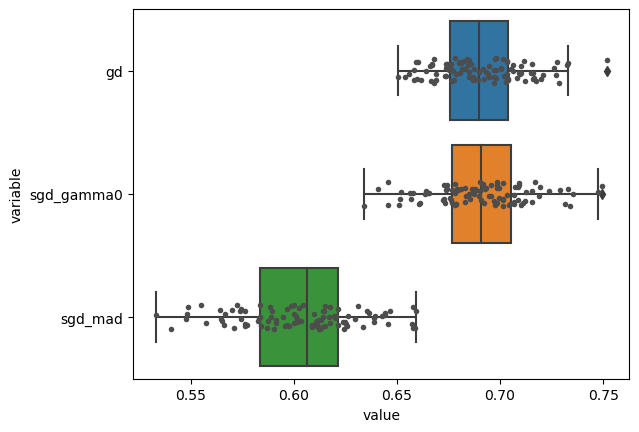

In [151]:
from tqdm import tqdm

@todataframe
def df():
    for name,spec in tqdm(specs.items()):
        train, test = np.stack([ gap(spec) for _ in range(100) ]).T
        yield [name, test]

sns.boxplot(x='value', y='variable', data=df.melt())
sns.stripplot(x='value', y='variable', data=df.melt(), size=4, color = '.3')